<a href="https://colab.research.google.com/github/xixiuqi/UNet_firebrand_segmentation/blob/main/UNetforfirebrand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-Net model for firebrand detection

U-Net is a simple fully convolutional neural network that is used for binary segmentation. U-Net is originally designed for the binary segmentation for medical application. U-Net has good performance in some simplified conditions.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle

# Data set

The data set is from the example images of firebrand. There are two folders, "Images" and "Annotations". The labelling is from lableme. https://github.com/labelmeai/labelme

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Pre-Processing



In [3]:
def image_generator(files, batch_size = 32, sz = (256, 256)):

  while True:

    #extract a random batch
    batch = np.random.choice(files, size = batch_size)

    #variables for collecting batches of inputs and outputs
    batch_x = []
    batch_y = []


    for f in batch:
        print(f)

        #get the masks. Note that masks are png files
        mask = Image.open(f'/content/drive/MyDrive/firebrandDetection/annotations/{f[:-4]}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask
        mask[mask >= 2] = 0
        mask[mask != 0 ] = 1

        batch_y.append(mask)

        #preprocess the raw images
        raw = Image.open(f'/content/drive/MyDrive/firebrandDetection/images/{f}')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)

In [29]:
batch_size = 5

all_files = os.listdir('/content/drive/MyDrive/firebrandDetection/images')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [23]:
x, y= next(train_generator)

158.png
72.png
45.png
82.png
68.png
34.png
145.png
35.png
11.png
148.png
161.png
49.png
196.png
137.png
197.png


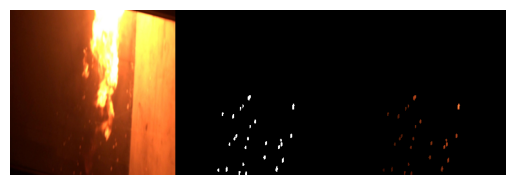

In [24]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [25]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# Model

In [26]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x

  #down sampling
  f = 8
  layers = []

  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64

  #bottleneck
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1

  #upsampling
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1


  #classification
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)

  #model creation
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])

  return model

  model = unet()

# Callbacks

In [27]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))

        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'/content/drive/MyDrive/firebrandDetection/images/{path}')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]

        #predict the mask
        pred = model.predict(np.expand_dims(raw, 0))

        #mask post-processing
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1
        msk[msk < 0.5] = 0

        #show the mask and the segmented image
        combined = np.concatenate([raw, msk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Traning

38
158.png
127.png
50.png
32.png
133.png
194.png
41.png
182.png
22.png
29.png
197.png
176.png
127.png
22.png
183.png
33.png
22.png
60.png
171.png
12.png
32.png
123.png
30.png
147.png
140.png
153.png
49.png
183.png
183.png
70.png
35.png
108.png
195.png
158.png
48.png
140.png
28.png
130.png
161.png
107.png
115.png
36.png
51.png
7.png
191.png
77.png
63.png
60.png
107.png
45.png
137.png
11.png
196.png
119.png
115.png
100.png
137.png
148.png
10.png
96.png
115.png
200.png
29.png
12.png
152.png
65.png
38.png
181.png
159.png
22.png
33.png
42.png
68.png
120.png
107.png
23.png
78.png
18.png
191.png
8.png
34.png
181.png
83.png
34.png
165.png
107.png
27.png
141.png
60.png
57.png
107.png
70.png
87.png
150.png
47.png
155.png
182.png
108.png
97.png
144.png
40.png
25.png
51.png
153.png
8.png
89.png
59.png
194.png
26.png
169.png
101.png
148.png
4.png
151.png
105.png
62.png
157.png
166.png
105.png
33.png
115.png
50.png
11.png
161.png
109.png
95.png
17.png
93.png
119.png
33.png
147.png
64.png
135.png
43.

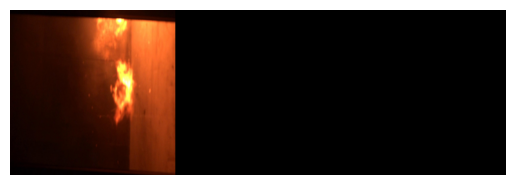

105.png
66.png
74.png
183.png
187.png
85.png
168.png
171.png
116.png
128.png
70.png
87.png
64.png
139.png
44.png
139.png
123.png
144.png
198.png
5.png
194.png
186.png
108.png
165.png
50.png
192.png
87.png
75.png
187.png
113.png
121.png
107.png
82.png
152.png
197.png
182.png
192.png
55.png
22.png
149.png
158.png
17.png
8.png
188.png
9.png
84.png
86.png
48.png
84.png
169.png
15.png
100.png
86.png
67.png
27.png
183.png
145.png
180.png
168.png
5.png
161.png
30.png
194.png
123.png
11.png
5.png
38.png
68.png
196.png
87.png
139.png
138.png
23.png
126.png
130.png
92.png
130.png
158.png
92.png
44.png
5.png
80.png
142.png
20.png
114.png
38.png
62.png
180.png
62.png
151.png
2.png
145.png
52.png
63.png
138.png
91.png
65.png
60.png
169.png
50.png
19.png
69.png
86.png
47.png
29.png
54.png
179.png
105.png
20.png
24.png
183.png
181.png
19.png
68.png
117.png
36.png
137.png
95.png
90.png
151.png
79.png
29.png
116.png
7.png
165.png
161.png
15.png
63.png
178.png
157.png
153.png
179.png
86.png
89.png
183.p

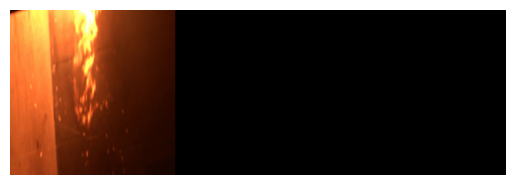

165.png
122.png
20.png
30.png
3.png
11.png
32.png
145.png
12.png
177.png
116.png
49.png
63.png
113.png
186.png
149.png
145.png
77.png
108.png
1.png
120.png
126.png
24.png
128.png
17.png
192.png
53.png
42.png
67.png
177.png
187.png
21.png
47.png
3.png
104.png
20.png
57.png
90.png
87.png
37.png
144.png
67.png
82.png
178.png
49.png
64.png
69.png
56.png
187.png
106.png
117.png
79.png
47.png
17.png
168.png
54.png
190.png
150.png
143.png
35.png
91.png
104.png
71.png
126.png
50.png
111.png
80.png
97.png
135.png
5.png
7.png
116.png
135.png
128.png
10.png
128.png
5.png
16.png
186.png
41.png
8.png
125.png
62.png
103.png
97.png
150.png
113.png
102.png
7.png
71.png
109.png
140.png
116.png
40.png
165.png
72.png
181.png
78.png
91.png
117.png
108.png
79.png
96.png
39.png
85.png
78.png
32.png
101.png
17.png
165.png
131.png
87.png
157.png
85.png
69.png
34.png
92.png
191.png
89.png
11.png
22.png
159.png
120.png
61.png
17.png
128.png
68.png
136.png
100.png
31.png
25.png
160.png
122.png
68.png
173.png
169

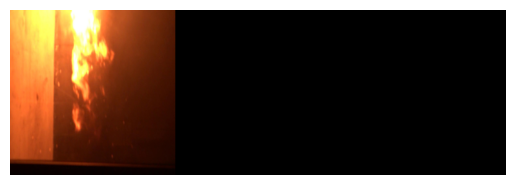

142.png
188.png
73.png
168.png
102.png
17.png
147.png
96.png
147.png
125.png
33.png
150.png
11.png
5.png
125.png
95.png
30.png
75.png
63.png
37.png
129.png
36.png
142.png
135.png
30.png
142.png
93.png
84.png
107.png
83.png
22.png
93.png
183.png
118.png
75.png
196.png
168.png
67.png
4.png
103.png
100.png
155.png
102.png
5.png
75.png
70.png
188.png
186.png
128.png
148.png
25.png
17.png
127.png
69.png
52.png
9.png
115.png
1.png
103.png
122.png
92.png
5.png
82.png
35.png
27.png
154.png
131.png
93.png
140.png
132.png
30.png
132.png
116.png
99.png
67.png
154.png
142.png
73.png
156.png
59.png
124.png
109.png
137.png
196.png
15.png
49.png
89.png
29.png
155.png
63.png
119.png
178.png
31.png
73.png
180.png
167.png
100.png
79.png
167.png
44.png
172.png
99.png
7.png
82.png
117.png
100.png
167.png
196.png
30.png
37.png
107.png
76.png
147.png
144.png
148.png
175.png
49.png
145.png
126.png
84.png
174.png
113.png
155.png
141.png
89.png
163.png
22.png
161.png
150.png
19.png
72.png
153.png
1.png
60.png


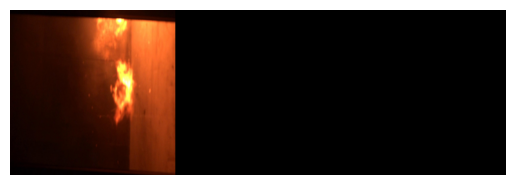

51.png
196.png
199.png
195.png
22.png
65.png
198.png
80.png
156.png
175.png
3.png
47.png
8.png
53.png
78.png
195.png
181.png
72.png
18.png
106.png
29.png
130.png
9.png
195.png
44.png
109.png
167.png
39.png
11.png
83.png
197.png
13.png
26.png
26.png
84.png
29.png
89.png
9.png
100.png
8.png
79.png
118.png
191.png
106.png
143.png
4.png
18.png
168.png
30.png
172.png
200.png
136.png
4.png
176.png
143.png
67.png
62.png
5.png
160.png
91.png
120.png
149.png
109.png
41.png
5.png
9.png
191.png
42.png
172.png
191.png
191.png
91.png
73.png
38.png
166.png
129.png
72.png
191.png
131.png
56.png
87.png
123.png
40.png
26.png
197.png
100.png
190.png
104.png
113.png
156.png
172.png
175.png
185.png
147.png
30.png
152.png
52.png
40.png
155.png
54.png
161.png
119.png
165.png
18.png
131.png
4.png
161.png
160.png
129.png
84.png
68.png
24.png
21.png
12.png
190.png
11.png
12.png
49.png
171.png
92.png
78.png
106.png
128.png
82.png
195.png
126.png
148.png
15.png
85.png
187.png
110.png
146.png
198.png
49.png
4.png

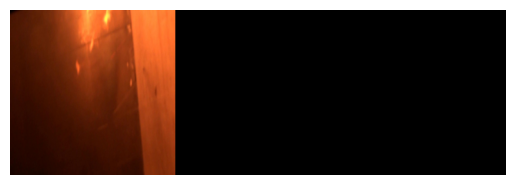

115.png
24.png
45.png
28.png
24.png
157.png
16.png
174.png
183.png
11.png
54.png
148.png
3.png
50.png
129.png
129.png
164.png
78.png
133.png
198.png
65.png
194.png
31.png
55.png
107.png
196.png
167.png
191.png
180.png
176.png
120.png
161.png
170.png
63.png
113.png
49.png
167.png
119.png
42.png
12.png
51.png
104.png
49.png
167.png
135.png
174.png
173.png
111.png
28.png
148.png
24.png
160.png
19.png
31.png
44.png
108.png
30.png
83.png
180.png
128.png
7.png
83.png
179.png
188.png
64.png
170.png
83.png
192.png
92.png
78.png
175.png
184.png
126.png
93.png
138.png
28.png
190.png
159.png
61.png
99.png
101.png
80.png
161.png
10.png
8.png
84.png
32.png
64.png
194.png
62.png
173.png
139.png
49.png
35.png
11.png
90.png
9.png
130.png
93.png
194.png
116.png
110.png
37.png
124.png
59.png
38.png
125.png
92.png
45.png
150.png
24.png
91.png
117.png
91.png
119.png
2.png
75.png
2.png
191.png
144.png
196.png
196.png
143.png
91.png
35.png
12.png
85.png
88.png
198.png
115.png
107.png
128.png
48.png
147.png


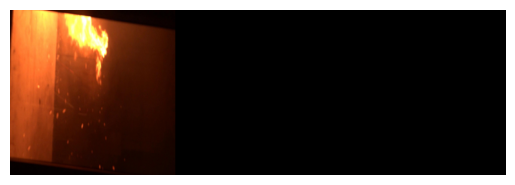

74.png
79.png
83.png
126.png
53.png
49.png
48.png
98.png
166.png
4.png
39.png
95.png
123.png
119.png
117.png
135.png
125.png
76.png
20.png
45.png
197.png
135.png
104.png
47.png
1.png
47.png
171.png
57.png
85.png
123.png
32.png
120.png
131.png
76.png
155.png
129.png
114.png
57.png
53.png
194.png
186.png
4.png
160.png
138.png
62.png
28.png
74.png
129.png
49.png
101.png
74.png
142.png
50.png
84.png
194.png
200.png
79.png
143.png
41.png
13.png
62.png
65.png
25.png
124.png
82.png
116.png
187.png
16.png
33.png
86.png
148.png
1.png
177.png
13.png
80.png
153.png
183.png
45.png
1.png
110.png
123.png
49.png
199.png
91.png
126.png
2.png
199.png
91.png
171.png
185.png
53.png
171.png
37.png
191.png
97.png
96.png
96.png
116.png
34.png
125.png
169.png
116.png
178.png
86.png
5.png
181.png
12.png
55.png
139.png
88.png
114.png
4.png
84.png
197.png
93.png
147.png
143.png
22.png
45.png
100.png
155.png
167.png
42.png
88.png
28.png
83.png
158.png
135.png
115.png
119.png
44.png
131.png
13.png
130.png
141.png

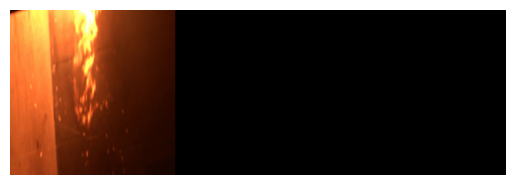

22.png
142.png
180.png
20.png
115.png
84.png
186.png
200.png
34.png
118.png
87.png
190.png
74.png
169.png
49.png
158.png
173.png
178.png
194.png
161.png
100.png
161.png
77.png
42.png
71.png
95.png
151.png
166.png
166.png
7.png
103.png
69.png
117.png
86.png
179.png
13.png
165.png
177.png
1.png
184.png
140.png
4.png
79.png
22.png
7.png
41.png
55.png
172.png
116.png
145.png
135.png
184.png
52.png
77.png
122.png
154.png
64.png
159.png
89.png
38.png
92.png
176.png
43.png
137.png
121.png
102.png
121.png
56.png
151.png
113.png
35.png
158.png
60.png
139.png
40.png
186.png
149.png
135.png
73.png
127.png
97.png
121.png
62.png
131.png
18.png
140.png
132.png
186.png
197.png
41.png
136.png
132.png
98.png
1.png
75.png
167.png
45.png
1.png
142.png
87.png
191.png
78.png
77.png
151.png
156.png
164.png
113.png
53.png
61.png
143.png
77.png
152.png
53.png
62.png
192.png
47.png
99.png
124.png
104.png
175.png
79.png
39.png
33.png
111.png
3.png
7.png
118.png
95.png
147.png
47.png
38.png
180.png
127.png
39.pn

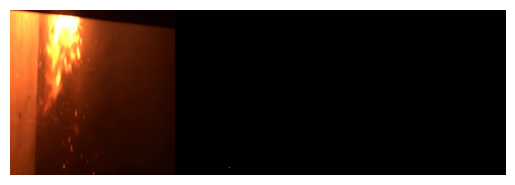

31.png
147.png
20.png
113.png
43.png
87.png
178.png
96.png
156.png
11.png
45.png
10.png
65.png
164.png
171.png
132.png
64.png
76.png
59.png
128.png
130.png
171.png
4.png
106.png
59.png
105.png
152.png
24.png
32.png
15.png
154.png
89.png
139.png
116.png
147.png
67.png
136.png
64.png
111.png
196.png
190.png
66.png
88.png
139.png
29.png
25.png
19.png
47.png
7.png
143.png
21.png
159.png
187.png
56.png
68.png
175.png
195.png
67.png
57.png
10.png
34.png
70.png
183.png
87.png
39.png
74.png
179.png
148.png
192.png
105.png
24.png
22.png
119.png
173.png
184.png
108.png
1.png
100.png
88.png
66.png
123.png
169.png
72.png
24.png
48.png
99.png
11.png
40.png
186.png
174.png
186.png
33.png
83.png
96.png
55.png
16.png
32.png
53.png
142.png
76.png
36.png
80.png
188.png
190.png
192.png
122.png
183.png
146.png
99.png
135.png
65.png
16.png
121.png
140.png
180.png
126.png
185.png
79.png
48.png
79.png
151.png
73.png
104.png
197.png
104.png
139.png
122.png
192.png
77.png
182.png
149.png
69.png
120.png
183.png

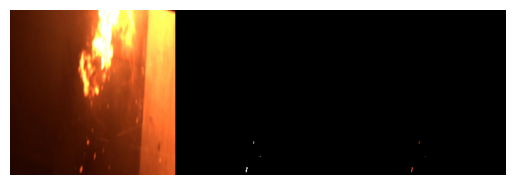

189.png
23.png
70.png
172.png
148.png
135.png
111.png
188.png
103.png
168.png
50.png
48.png
47.png
91.png
173.png
107.png
33.png
121.png
27.png
183.png
51.png
4.png
154.png
50.png
104.png
128.png
98.png
136.png
36.png
150.png
7.png
138.png
115.png
48.png
113.png
92.png
115.png
19.png
114.png
183.png
24.png
47.png
176.png
151.png
152.png
50.png
29.png
176.png
61.png
170.png
159.png
150.png
136.png
178.png
91.png
178.png
5.png
29.png
163.png
111.png
3.png
133.png
191.png
116.png
156.png
196.png
157.png
69.png
62.png
148.png
102.png
54.png
127.png
198.png
3.png
85.png
76.png
65.png
63.png
189.png
72.png
92.png
92.png
65.png
78.png
2.png
30.png
80.png
13.png
181.png
99.png
180.png
163.png
171.png
150.png
9.png
167.png
167.png
54.png
163.png
105.png
18.png
2.png
176.png
95.png
177.png
47.png
5.png
75.png
114.png
132.png
5.png
21.png
197.png
18.png
147.png
51.png
13.png
161.png
195.png
158.png
194.png
113.png
169.png
123.png
197.png
190.png
49.png
133.png
4.png
18.png
181.png
47.png
127.png


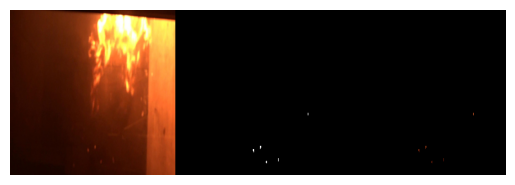

62.png
154.png
90.png
143.png
132.png
8.png
89.png
132.png
191.png
62.png
91.png
84.png
87.png
171.png
104.png
45.png
52.png
75.png
7.png
115.png
83.png
75.png
158.png
113.png
128.png
117.png
140.png
192.png
191.png
98.png
169.png
185.png
40.png
5.png
51.png
115.png
135.png
8.png
62.png
159.png
189.png
187.png
111.png
195.png
164.png
27.png
137.png
52.png
135.png
2.png
129.png
63.png
133.png
54.png
142.png
167.png
198.png
129.png
146.png
166.png
143.png
175.png
117.png
62.png
28.png
164.png
154.png
175.png
149.png
154.png
35.png
133.png
10.png
65.png
118.png
76.png
89.png
98.png
62.png
109.png
123.png
73.png
176.png
106.png
21.png
178.png
28.png
110.png
198.png
5.png
117.png
47.png
28.png
71.png
197.png
93.png
177.png
89.png
31.png
101.png
47.png
124.png
117.png
42.png
107.png
84.png
56.png
13.png
84.png
127.png
119.png
190.png
59.png
104.png
78.png
43.png
7.png
173.png
168.png
93.png
115.png
172.png
97.png
43.png
168.png
84.png
116.png
151.png
71.png
150.png
85.png
76.png
161.png
184.

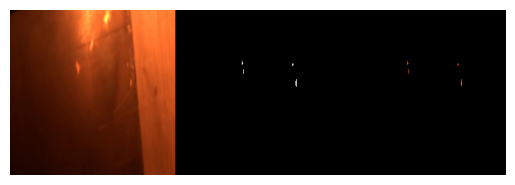

106.png
169.png
153.png
67.png
60.png
51.png
35.png
198.png
130.png
73.png
53.png
173.png
195.png
2.png
70.png
71.png
42.png
157.png
130.png
111.png
80.png
189.png
195.png
168.png
84.png
154.png
82.png
123.png
191.png
68.png
87.png
8.png
86.png
37.png
124.png
50.png
90.png
66.png
76.png
77.png
133.png
40.png
194.png
77.png
4.png
96.png
178.png
55.png
77.png
64.png
63.png
174.png
114.png
110.png
110.png
147.png
165.png
184.png
39.png
35.png
146.png
62.png
32.png
190.png
121.png
61.png
61.png
143.png
158.png
117.png
199.png
130.png
16.png
111.png
156.png
51.png
141.png
153.png
32.png
55.png
199.png
186.png
141.png
116.png
120.png
116.png
26.png
127.png
79.png
124.png
179.png
86.png
66.png
36.png
150.png
123.png
50.png
80.png
190.png
110.png
28.png
155.png
184.png
45.png
13.png
90.png
71.png
76.png
91.png
191.png
198.png
80.png
2.png
20.png
187.png
27.png
185.png
200.png
71.png
131.png
64.png
26.png
84.png
43.png
66.png
93.png
54.png
139.png
61.png
84.png
72.png
128.png
144.png
182.png
13

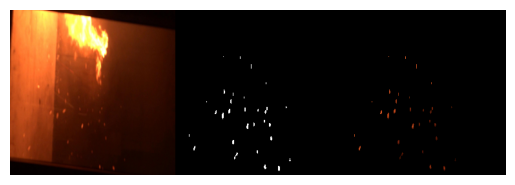

85.png
120.png
170.png
62.png
148.png
68.png
57.png
59.png
64.png
88.png
26.png
101.png
70.png
55.png
34.png
99.png
10.png
105.png
126.png
4.png
60.png
172.png
91.png
185.png
136.png
10.png
194.png
37.png
105.png
174.png
130.png
83.png
178.png
172.png
165.png
113.png
37.png
63.png
33.png
141.png
72.png
11.png
127.png
194.png
187.png
185.png
57.png
77.png
178.png
89.png
9.png
110.png
131.png
187.png
133.png
158.png
84.png
174.png
177.png
53.png
35.png
199.png
73.png
149.png
64.png
148.png
65.png
118.png
92.png
39.png
44.png
118.png
49.png
149.png
171.png
47.png
133.png
153.png
71.png
99.png
195.png
197.png
191.png
50.png
192.png
35.png
73.png
40.png
74.png
86.png
121.png
26.png
184.png
161.png
63.png
197.png
56.png
78.png
10.png
127.png
39.png
177.png
61.png
25.png
103.png
53.png
73.png
91.png
60.png
51.png
199.png
92.png
43.png
10.png
196.png
157.png
19.png
130.png
171.png
8.png
184.png
76.png
9.png
174.png
98.png
88.png
71.png
166.png
100.png
116.png
1.png
181.png
110.png
142.png
21.p

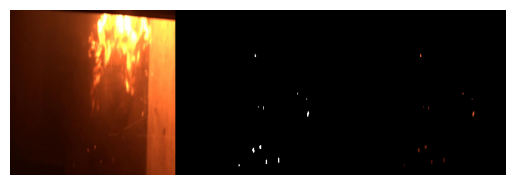

53.png
200.png
71.png
136.png
24.png
82.png
185.png
49.png
66.png
107.png
149.png
1.png
146.png
83.png
99.png
117.png
186.png
86.png
92.png
84.png
179.png
109.png
86.png
98.png
80.png
92.png
191.png
35.png
149.png
104.png
16.png
57.png
24.png
129.png
172.png
38.png
37.png
30.png
55.png
107.png
30.png
37.png
3.png
23.png
95.png
130.png
179.png
40.png
163.png
13.png
126.png
30.png
176.png
61.png
80.png
178.png
146.png
74.png
175.png
44.png
47.png
38.png
99.png
130.png
26.png
127.png
136.png
56.png
19.png
89.png
22.png
4.png
75.png
114.png
28.png
78.png
36.png
194.png
1.png
63.png
171.png
106.png
130.png
63.png
127.png
4.png
195.png
186.png
89.png
57.png
48.png
142.png
195.png
121.png
156.png
34.png
115.png
113.png
25.png
116.png
29.png
15.png
132.png
199.png
18.png
27.png
69.png
40.png
179.png
47.png
199.png
7.png
18.png
60.png
96.png
131.png
165.png
107.png
155.png
60.png
47.png
104.png
53.png
40.png
123.png
89.png
155.png
197.png
83.png
44.png
192.png
61.png
55.png
36.png
13.png
165.pn

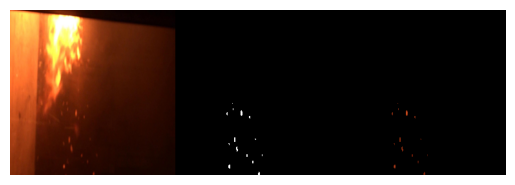

131.png
5.png
50.png
38.png
161.png
178.png
125.png
1.png
172.png
123.png
129.png
164.png
61.png
19.png
172.png
108.png
37.png
25.png
1.png
76.png
132.png
80.png
41.png
56.png
32.png
176.png
53.png
64.png
66.png
54.png
88.png
141.png
167.png
51.png
183.png
187.png
163.png
124.png
106.png
69.png
66.png
8.png
161.png
170.png
128.png
125.png
33.png
9.png
189.png
113.png
15.png
11.png
21.png
92.png
75.png
108.png
142.png
107.png
148.png
142.png
79.png
68.png
57.png
29.png
37.png
72.png
52.png
139.png
31.png
15.png
62.png
52.png
167.png
17.png
72.png
55.png
40.png
86.png
130.png
67.png
146.png
177.png
33.png
108.png
182.png
157.png
92.png
70.png
41.png
34.png
139.png
110.png
13.png
99.png
111.png
149.png
138.png
156.png
35.png
84.png
140.png
169.png
26.png
77.png
183.png
163.png
114.png
66.png
48.png
178.png
151.png
135.png
108.png
76.png
109.png
67.png
187.png
62.png
31.png
178.png
62.png
191.png
95.png
111.png
176.png
111.png
22.png
75.png
170.png
171.png
92.png
41.png
188.png
95.png
192.

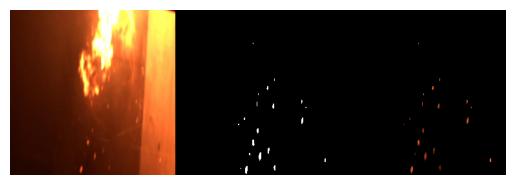

161.png
161.png
111.png
73.png
77.png
129.png
78.png
188.png
18.png
163.png
89.png
34.png
99.png
198.png
188.png
142.png
135.png
195.png
26.png
124.png
200.png
64.png
158.png
83.png
119.png
108.png
47.png
45.png
115.png
74.png
116.png
11.png
88.png
96.png
124.png
198.png
20.png
85.png
132.png
104.png
60.png
60.png
168.png
74.png
169.png
99.png
189.png
85.png
30.png
186.png
171.png
127.png
196.png
108.png
191.png
45.png
117.png
48.png
151.png
113.png
52.png
38.png
140.png
95.png
69.png
91.png
157.png
42.png
34.png
38.png
146.png
155.png
45.png
57.png
198.png
116.png
1.png
43.png
176.png
173.png
158.png
135.png
170.png
32.png
99.png
139.png
143.png
113.png
53.png
143.png
95.png
93.png
116.png
55.png
128.png
104.png
49.png
167.png
197.png
194.png
10.png
18.png
166.png
16.png
121.png
179.png
19.png
86.png
173.png
127.png
102.png
165.png
52.png
87.png
129.png
123.png
65.png
71.png
19.png
41.png
56.png
18.png
184.png
33.png
157.png
168.png
92.png
144.png
93.png
55.png
20.png
125.png
168.png


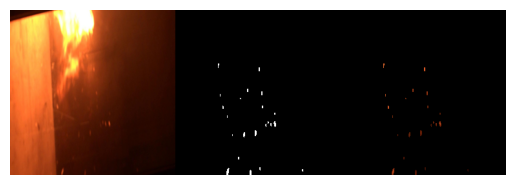

67.png
95.png
163.png
198.png
149.png
150.png
171.png
109.png
73.png
184.png
41.png
56.png
70.png
180.png
49.png
2.png
121.png
91.png
64.png
105.png
149.png
36.png
154.png
21.png
108.png
33.png
138.png
93.png
146.png
105.png
96.png
125.png
129.png
181.png
16.png
15.png
10.png
124.png
34.png
66.png
20.png
105.png
119.png
129.png
177.png
78.png
22.png
99.png
197.png
52.png
199.png
56.png
172.png
89.png
135.png
74.png
187.png
17.png
128.png
123.png
133.png
22.png
24.png
133.png
63.png
29.png
97.png
197.png
72.png
63.png
28.png
84.png
77.png
120.png
154.png
27.png
20.png
55.png
197.png
74.png
126.png
99.png
138.png
26.png
122.png
161.png
105.png
176.png
47.png
72.png
152.png
114.png
178.png
124.png
139.png
65.png
129.png
28.png
33.png
16.png
21.png
156.png
137.png
120.png
177.png
150.png
142.png
136.png
41.png
150.png
52.png
64.png
118.png
145.png
118.png
53.png
63.png
38.png
60.png
105.png
117.png
13.png
70.png
75.png
1.png
39.png
194.png
156.png
165.png
90.png
174.png
156.png
128.png
53.

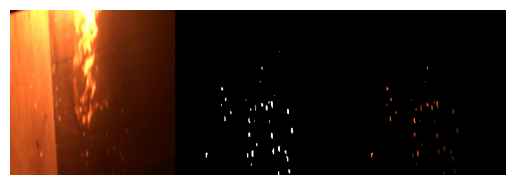

51.png
119.png
35.png
20.png
121.png
109.png
151.png
23.png
93.png
122.png
28.png
62.png
166.png
190.png
133.png
54.png
106.png
155.png
12.png
5.png
137.png
159.png
69.png
189.png
136.png
52.png
178.png
66.png
197.png
122.png
80.png
56.png
158.png
41.png
157.png
77.png
199.png
175.png
115.png
20.png
117.png
93.png
104.png
3.png
123.png
98.png
91.png
135.png
151.png
176.png
197.png
187.png
21.png
161.png
54.png
166.png
35.png
65.png
105.png
169.png
184.png
113.png
149.png
173.png
84.png
23.png
72.png
186.png
79.png
109.png
79.png
48.png
11.png
15.png
173.png
183.png
157.png
127.png
15.png
19.png
177.png
124.png
63.png
40.png
86.png
137.png
103.png
122.png
90.png
175.png
180.png
117.png
176.png
177.png
107.png
86.png
111.png
170.png
35.png
105.png
196.png
31.png
23.png
52.png
106.png
166.png
115.png
41.png
33.png
129.png
111.png
40.png
195.png
189.png
53.png
89.png
106.png
51.png
159.png
29.png
157.png
183.png
91.png
98.png
35.png
75.png
127.png
27.png
174.png
105.png
2.png
8.png
72.png


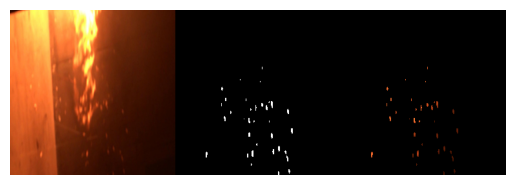

185.png
34.png
48.png
13.png
16.png
20.png
155.png
56.png
26.png
159.png
25.png
118.png
82.png
89.png
163.png
187.png
30.png
159.png
15.png
96.png
129.png
65.png
23.png
7.png
47.png
133.png
118.png
93.png
38.png
98.png
101.png
199.png
198.png
130.png
110.png
28.png
90.png
155.png
174.png
95.png
144.png
26.png
197.png
27.png
146.png
137.png
174.png
90.png
157.png
69.png
115.png
22.png
10.png
74.png
157.png
105.png
67.png
109.png
5.png
99.png
92.png
153.png
77.png
75.png
113.png
184.png
67.png
92.png
16.png
169.png
186.png
60.png
149.png
186.png
43.png
133.png
165.png
101.png
79.png
177.png
73.png
149.png
59.png
118.png
36.png
86.png
168.png
181.png
136.png
73.png
171.png
125.png
157.png
192.png
33.png
111.png
53.png
7.png
155.png
183.png
82.png
29.png
53.png
124.png
52.png
120.png
23.png
125.png
154.png
72.png
15.png
126.png
155.png
173.png
154.png
99.png
8.png
5.png
52.png
16.png
37.png
143.png
25.png
182.png
122.png
159.png
15.png
50.png
32.png
42.png
199.png
82.png
24.png
69.png
55.p

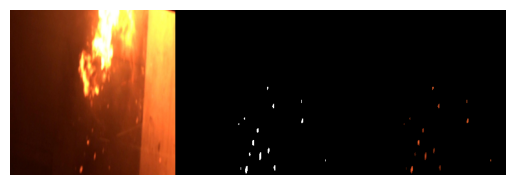

71.png
151.png
78.png
175.png
185.png
101.png
95.png
176.png
109.png
158.png
42.png
178.png
99.png
89.png
51.png
97.png
179.png
161.png
182.png
110.png
166.png
65.png
61.png
82.png
113.png
37.png
172.png
2.png
21.png
9.png
23.png
140.png
98.png
42.png
166.png
140.png
189.png
92.png
24.png
137.png
135.png
174.png
43.png
153.png
41.png
77.png
43.png
107.png
105.png
97.png
188.png
4.png
145.png
133.png
194.png
119.png
133.png
121.png
37.png
105.png
158.png
191.png
33.png
156.png
103.png
7.png
10.png
55.png
56.png
189.png
173.png
128.png
195.png
69.png
113.png
44.png
105.png
30.png
18.png
106.png
28.png
118.png
196.png
30.png
164.png
25.png
126.png
12.png
186.png
75.png
122.png
80.png
155.png
28.png
71.png
89.png
16.png
157.png
199.png
108.png
55.png
85.png
43.png
95.png
183.png
90.png
28.png
166.png
38.png
23.png
160.png
180.png
24.png
113.png
32.png
84.png
15.png
135.png
40.png
23.png
106.png
27.png
169.png
66.png
68.png
77.png
168.png
172.png
74.png
109.png
155.png
100.png
173.png
38.pn

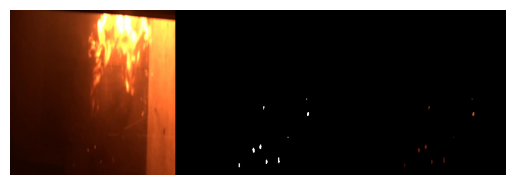

37.png
44.png
42.png
190.png
173.png
115.png
91.png
119.png
171.png
199.png
63.png
124.png
47.png
88.png
198.png
59.png
176.png
34.png
61.png
62.png
18.png
1.png
4.png
4.png
189.png
32.png
161.png
200.png
32.png
123.png
138.png
101.png
200.png
188.png
127.png
92.png
17.png
25.png
90.png
1.png
158.png
177.png
51.png
194.png
19.png
67.png
184.png
179.png
182.png
76.png
40.png
64.png
90.png
28.png
130.png
154.png
2.png
133.png
11.png
110.png
19.png
49.png
18.png
92.png
64.png
144.png
37.png
28.png
165.png
157.png
87.png
199.png
166.png
126.png
44.png
147.png
144.png
122.png
7.png
171.png
178.png
190.png
127.png
4.png
184.png
19.png
154.png
54.png
119.png
198.png
98.png
27.png
12.png
52.png
187.png
172.png
148.png
146.png
125.png
12.png
78.png
157.png
186.png
35.png
160.png
141.png
62.png
56.png
123.png
109.png
55.png
153.png
37.png
38.png
182.png
1.png
86.png
125.png
95.png
141.png
184.png
120.png
49.png
48.png
136.png
24.png
163.png
137.png
39.png
105.png
30.png
192.png
53.png
139.png
14

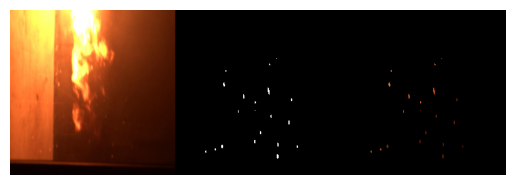

25.png
149.png
73.png
137.png
63.png
137.png
99.png
120.png
186.png
145.png
133.png
198.png
95.png
143.png
87.png
13.png
100.png
83.png
197.png
27.png
22.png
191.png
186.png
89.png
85.png
105.png
71.png
102.png
33.png
87.png
185.png
40.png
108.png
42.png
182.png
180.png
25.png
52.png
145.png
5.png
25.png
31.png
145.png
140.png
85.png
31.png
184.png
61.png
95.png
152.png
77.png
75.png
11.png
74.png
35.png
126.png
85.png
192.png
102.png
188.png
40.png
125.png
48.png
102.png
163.png
75.png
36.png
103.png
117.png
80.png
45.png
105.png
64.png
124.png
132.png
51.png
191.png
128.png
103.png
76.png
92.png
148.png
166.png
2.png
111.png
165.png
12.png
200.png
2.png
27.png
152.png
181.png
114.png
196.png
167.png
42.png
154.png
158.png
18.png
117.png
56.png
26.png
20.png
198.png
5.png
184.png
189.png
74.png
115.png
145.png
59.png
67.png
198.png
145.png
197.png
142.png
50.png
115.png
104.png
157.png
155.png
11.png
192.png
147.png
167.png
31.png
2.png
30.png
113.png
44.png
89.png
178.png
103.png
156

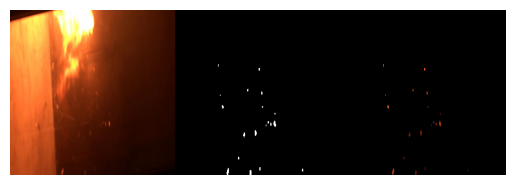

130.png
100.png
170.png
170.png
27.png
144.png
21.png
30.png
200.png
37.png
24.png
102.png
198.png
192.png
150.png
180.png
170.png
153.png
144.png
111.png
21.png
164.png
53.png
107.png
12.png
151.png
191.png
163.png
45.png
184.png
124.png
31.png
105.png
168.png
130.png
181.png
34.png
16.png
95.png
82.png
78.png
144.png
68.png
54.png
60.png
1.png
132.png
29.png
60.png
127.png
104.png
156.png
140.png
10.png
72.png
31.png
197.png
161.png
186.png
178.png
55.png
174.png
84.png
136.png
11.png
4.png
149.png
57.png
98.png
52.png
62.png
133.png
47.png
64.png
179.png
198.png
137.png
137.png
174.png
24.png
119.png
131.png
76.png
25.png
120.png
177.png
155.png
127.png
151.png
37.png
161.png
118.png
104.png
10.png
136.png
198.png
15.png
152.png
118.png
22.png
45.png
186.png
7.png
99.png
38.png
157.png
116.png
105.png
61.png
136.png
135.png
9.png
105.png
122.png
53.png
69.png
159.png
17.png
84.png
48.png
3.png
40.png
199.png
106.png
90.png
27.png
150.png
158.png
74.png
2.png
44.png
114.png
43.png
8.

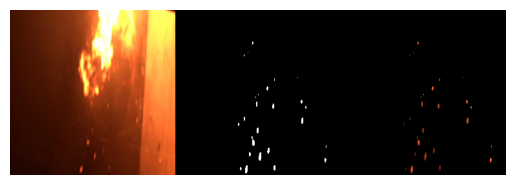

68.png
187.png
123.png
57.png
141.png
146.png
87.png
194.png
91.png
154.png
37.png
198.png
143.png
144.png
183.png
147.png
189.png
196.png
115.png
160.png
116.png
21.png
12.png
123.png
108.png
32.png
150.png
86.png
18.png
156.png
87.png
113.png
52.png
15.png
79.png
114.png
120.png
191.png
71.png
175.png
182.png
163.png
110.png
55.png
171.png
29.png
9.png
10.png
157.png
126.png
145.png
116.png
163.png
110.png
23.png
17.png
74.png
76.png
25.png
148.png
157.png
88.png
47.png
107.png
65.png
198.png
36.png
168.png
52.png
170.png
22.png
105.png
32.png
128.png
84.png
190.png
99.png
84.png
86.png
148.png
92.png
95.png
37.png
41.png
55.png
75.png
181.png
176.png
165.png
39.png
196.png
49.png
29.png
173.png
3.png
44.png
28.png
173.png
41.png
59.png
91.png
28.png
197.png
40.png
102.png
102.png
54.png
71.png
60.png
95.png
90.png
191.png
131.png
75.png
121.png
169.png
21.png
159.png
107.png
96.png
1.png
32.png
189.png
199.png
122.png
23.png
163.png
160.png
192.png
131.png
102.png
68.png
123.png
70.

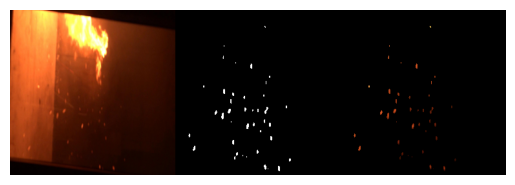

153.png
36.png
33.png
119.png
9.png
83.png
92.png
159.png
19.png
40.png
166.png
88.png
70.png
28.png
155.png
35.png
100.png
90.png
104.png
183.png
198.png
153.png
199.png
132.png
26.png
132.png
82.png
60.png
76.png
160.png
89.png
135.png
173.png
54.png
153.png
95.png
172.png
53.png
118.png
93.png
55.png
155.png
166.png
85.png
125.png
88.png
86.png
127.png
79.png
1.png
131.png
194.png
122.png
133.png
186.png
2.png
39.png
149.png
190.png
187.png
150.png
18.png
138.png
7.png
64.png
173.png
21.png
42.png
175.png
183.png
137.png
153.png
11.png
50.png
108.png
142.png
20.png
11.png
66.png
60.png
166.png
91.png
57.png
95.png
41.png
55.png
90.png
175.png
103.png
121.png
67.png
43.png
13.png
171.png
123.png
24.png
195.png
44.png
62.png
9.png
71.png
118.png
38.png
93.png
198.png
31.png
148.png
136.png
169.png
99.png
120.png
68.png
44.png
148.png
126.png
127.png
111.png
73.png
115.png
48.png
136.png
99.png
146.png
113.png
173.png
40.png
116.png
164.png
133.png
9.png
185.png
26.png
168.png
41.png
4

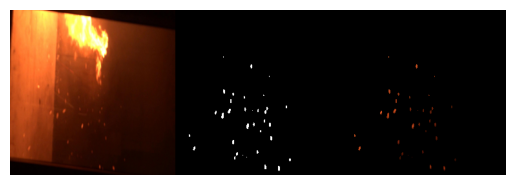

45.png
104.png
190.png
181.png
82.png
55.png
126.png
106.png
160.png
75.png
49.png
11.png
105.png
130.png
105.png
2.png
194.png
186.png
63.png
90.png
47.png
48.png
154.png
172.png
57.png
183.png
185.png
153.png
96.png
135.png
119.png
127.png
40.png
5.png
170.png
8.png
194.png
150.png
44.png
8.png
84.png
182.png
186.png
165.png
188.png
152.png
106.png
139.png
54.png
197.png
194.png
164.png
166.png
92.png
108.png
142.png
96.png
178.png
148.png
84.png
167.png
65.png
56.png
167.png
22.png
138.png
18.png
3.png
189.png
60.png
52.png
172.png
105.png
20.png
168.png
109.png
103.png
157.png
110.png
125.png
8.png
74.png
36.png
83.png
91.png
161.png
93.png
84.png
70.png
192.png
122.png
153.png
99.png
20.png
59.png
171.png
84.png
15.png
30.png
31.png
44.png
16.png
13.png
24.png
45.png
150.png
74.png
45.png
35.png
7.png
27.png
145.png
22.png
148.png
141.png
72.png
86.png
5.png
64.png
24.png
198.png
20.png
200.png
149.png
12.png
184.png
52.png
132.png
24.png
89.png
165.png
79.png
57.png
89.png
156.pn

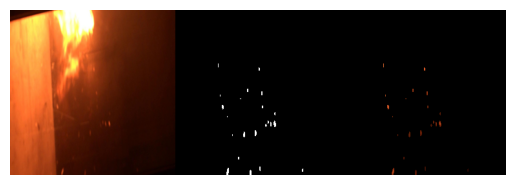

100.png
88.png
105.png
41.png
140.png
11.png
120.png
73.png
56.png
179.png
4.png
111.png
136.png
83.png
31.png
176.png
123.png
21.png
18.png
34.png
55.png
124.png
77.png
158.png
21.png
137.png
175.png
199.png
45.png
52.png
140.png
155.png
163.png
196.png
161.png
12.png
89.png
39.png
109.png
186.png
52.png
7.png
119.png
48.png
90.png
183.png
130.png
166.png
34.png
178.png
111.png
68.png
153.png
9.png
194.png
10.png
151.png
175.png
136.png
21.png
183.png
44.png
87.png
139.png
185.png
15.png
123.png
192.png
143.png
74.png
17.png
135.png
119.png
101.png
132.png
7.png
21.png
144.png
188.png
148.png
135.png
155.png
90.png
57.png
68.png
168.png
85.png
133.png
186.png
95.png
62.png
66.png
52.png
61.png
21.png
146.png
37.png
52.png
28.png
173.png
128.png
128.png
97.png
111.png
189.png
60.png
148.png
90.png
69.png
158.png
35.png
142.png
116.png
49.png
72.png
170.png
150.png
173.png
78.png
72.png
43.png
48.png
136.png
53.png
63.png
38.png
93.png
156.png
63.png
188.png
52.png
104.png
76.png
103.pn

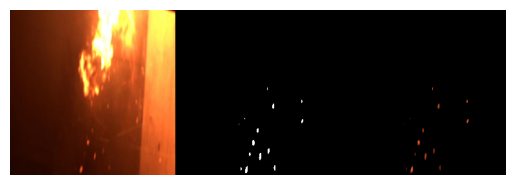

65.png
117.png
157.png
122.png
151.png
148.png
163.png
163.png
185.png
151.png
169.png
182.png
153.png
90.png
65.png
71.png
152.png
90.png
195.png
144.png
170.png
147.png
191.png
80.png
64.png
34.png
159.png
12.png
66.png
54.png
44.png
149.png
77.png
132.png
24.png
139.png
102.png
195.png
147.png
5.png
199.png
39.png
177.png
109.png
7.png
73.png
77.png
188.png
135.png
199.png
113.png
147.png
171.png
72.png
144.png
60.png
99.png
120.png
73.png
13.png
167.png
189.png
30.png
119.png
165.png
52.png
154.png
192.png
139.png
10.png
151.png
100.png
129.png
123.png
182.png
3.png
114.png
61.png
111.png
127.png
181.png
175.png
177.png
66.png
116.png
8.png
76.png
32.png
186.png
68.png
82.png
154.png
85.png
53.png
138.png
85.png
105.png
43.png
54.png
77.png
60.png
117.png
170.png
24.png
152.png
120.png
26.png
10.png
87.png
129.png
186.png
118.png
34.png
169.png
70.png
168.png
165.png
10.png
80.png
2.png
95.png
50.png
137.png
65.png
110.png
120.png
35.png
133.png
133.png
44.png
159.png
106.png
21.pn

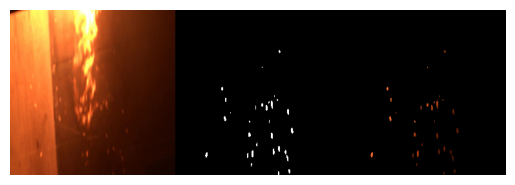

105.png
37.png
121.png
115.png
47.png
109.png
24.png
30.png
60.png
100.png
191.png
98.png
131.png
185.png
45.png
113.png
82.png
182.png
5.png
126.png
37.png
156.png
3.png
135.png
79.png
190.png
127.png
177.png
187.png
101.png
136.png
77.png
180.png
48.png
180.png
68.png
92.png
50.png
119.png
105.png
114.png
96.png
62.png
82.png
99.png
136.png
32.png
169.png
2.png
186.png
36.png
26.png
3.png
33.png
197.png
120.png
135.png
65.png
115.png
55.png
188.png
39.png
92.png
143.png
104.png
15.png
194.png
136.png
70.png
159.png
108.png
7.png
139.png
60.png
180.png
59.png
93.png
161.png
165.png
192.png
188.png
152.png
133.png
82.png
121.png
192.png
4.png
138.png
55.png
27.png
186.png
133.png
2.png
182.png
195.png
144.png
85.png
73.png
16.png
56.png
135.png
99.png
61.png
42.png
188.png
145.png
168.png
200.png
159.png
15.png
21.png
111.png
55.png
197.png
23.png
28.png
102.png
50.png
68.png
53.png
9.png
128.png
1.png
167.png
199.png
91.png
43.png
63.png
36.png
171.png
99.png
16.png
25.png
174.png
147

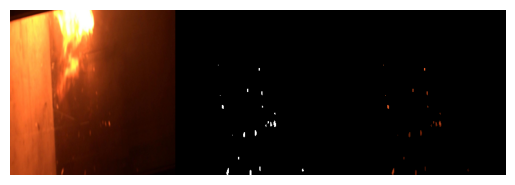

77.png
165.png
97.png
118.png
23.png
93.png
60.png
5.png
26.png
146.png
80.png
15.png
137.png
33.png
77.png
105.png
93.png
90.png
196.png
183.png
34.png
29.png
111.png
166.png
53.png
148.png
53.png
129.png
174.png
169.png
128.png
131.png
33.png
92.png
118.png
102.png
165.png
78.png
3.png
85.png
131.png
195.png
149.png
30.png
62.png
150.png
142.png
184.png
184.png
149.png
49.png
121.png
153.png
7.png
82.png
143.png
13.png
169.png
186.png
113.png
177.png
32.png
168.png
66.png
184.png
84.png
107.png
50.png
21.png
175.png
196.png
118.png
41.png
33.png
158.png
73.png
130.png
31.png
98.png
99.png
67.png
149.png
159.png
25.png
18.png
59.png
95.png
36.png
176.png
89.png
145.png
177.png
75.png
40.png
1.png
75.png
32.png
82.png
111.png
56.png
36.png
5.png
54.png
83.png
47.png
157.png
101.png
182.png
92.png
60.png
200.png
55.png
33.png
37.png
4.png
168.png
9.png
107.png
136.png
132.png
124.png
166.png
128.png
153.png
30.png
165.png
98.png
4.png
88.png
86.png
175.png
52.png
148.png
180.png
188.png

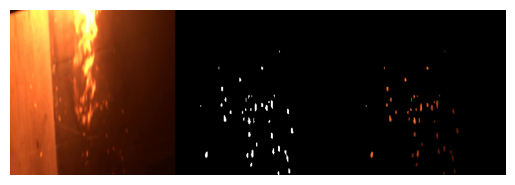

In [30]:
model = unet()

train_steps = len(train_files) //batch_size
print(train_steps)
test_steps = len(test_files) //batch_size
model.fit(train_generator,
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 0)

# Prediction

In [ ]:
raw = Image.open('test.jpg')
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1
msk[msk < 0.5] = 0

#show the mask and the segmented image
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()